In [1]:
from zernike_algos import (
    ZernikePolynomial,
    zernike_radial,
    zernike_radial_optimized,
    zernike_radial_coeffs,
    zernike_radial_poly
)
from zernike_prata import ZerothDerivative
import numpy as np
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import mpmath
import sys
import time
np.set_printoptions(threshold=sys.maxsize)

In [17]:
basis = ZernikePolynomial(L=50, M=50, spectral_indexing="ansi", sym="cos")
# prata's algo's derivatives has a problem with r = 0 
r = np.linspace(0.001, 1, 100)
radial = zernike_radial(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 0)

In [16]:
%timeit zernike_radial(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 0)

1.51 ms ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [3]:
print("zernike_radial, 0th derivative")
%timeit zernike_radial(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()

zernike_radial, 0th derivative
1.55 ms ± 13 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
basis = ZernikePolynomial(L=50, M=50, spectral_indexing="ansi", sym="cos")
r = np.linspace(0.001, 1, 100)
l = basis.modes[:,0]
m = basis.modes[:,1]

jacobi_values = zernike_radial_optimized(x=r, l=l, m=m)

4.06 ms ± 36.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit zernike_radial_optimized(x=r, l=l, m=m)

There are a couple problems concerning speed with the prata algo code:
- some polynomials that don't exist are attempted to be calculated
- edge cases are sometimes not calculated

In [13]:
f = ZerothDerivative(r, l)
%timeit f.zernike_radial_prata()

1.76 ms ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


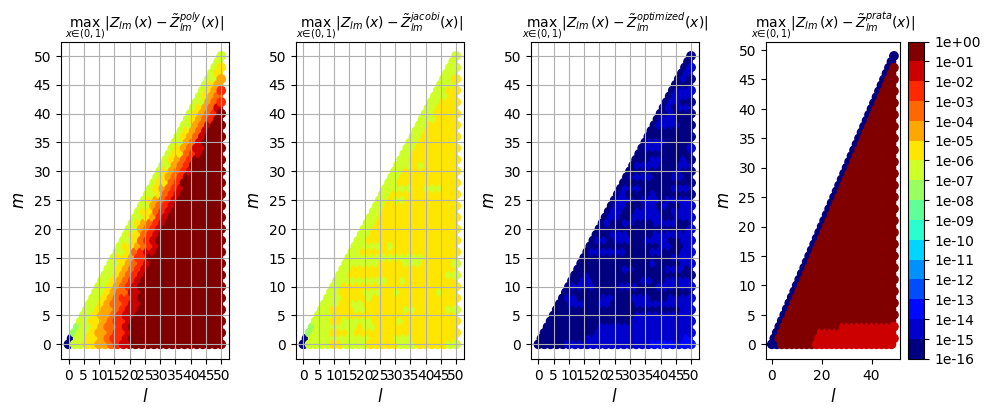

In [24]:
mpmath.mp.dps = 100
c = zernike_radial_coeffs(basis.modes[:, 0], basis.modes[:, 1], exact=True)

# current algorithm
zr0 = radial
# exact evaluation
zt0 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in c]).T
# polynomial evaluation
zp0 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=0, exact=False
)

cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "Custom cmap", cmaplist, cmap.N
)

# define the bins and normalize
bounds = np.logspace(-16, 0, 17)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots(1, 4, squeeze=True, figsize=(10, 4))
im = ax[0].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zp0 - zt0), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[1].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zr0 - zt0), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[2].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(jacobi_values - zt0), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[3].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(f.get_zeroth_derivative()[l, m].T - zt0), axis=0),
    norm=norm,
    cmap=cmap,
)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].set_xticks(np.arange(0, 55, 5))
ax[0].set_yticks(np.arange(0, 55, 5))
ax[1].set_xticks(np.arange(0, 55, 5))
ax[1].set_yticks(np.arange(0, 55, 5))
ax[2].set_xticks(np.arange(0, 55, 5))
ax[2].set_yticks(np.arange(0, 55, 5))
ax[3].set_yticks(np.arange(0, 55, 5))
ax[0].set_xlabel("$l$", fontsize=12)
ax[0].set_ylabel("$m$", fontsize=12)
ax[1].set_xlabel("$l$", fontsize=12)
ax[1].set_ylabel("$m$", fontsize=12)
ax[2].set_xlabel("$l$", fontsize=12)
ax[2].set_ylabel("$m$", fontsize=12)
ax[3].set_xlabel("$l$", fontsize=12)
ax[3].set_ylabel("$m$", fontsize=12)
plt.tight_layout()
ax[0].set_title(
    "$\max_{x \in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{poly}(x)|$", fontsize=10
)
ax[1].set_title(
    "$\max_{x \in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{jacobi}(x)|$", fontsize=10
);
ax[2].set_title(
    "$\max_{x \in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{optimized}(x)|$", fontsize=10
);
ax[3].set_title(
    "$\max_{x \in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{prata}(x)|$", fontsize=10
);